In [55]:
!pip install pyspark

In [56]:
from pyspark.sql import SparkSession

In [57]:
# Create the spark session with the name 'Match Analysis and prediction'

spark = SparkSession.builder.appName('Match Analysis and prediction').getOrCreate()

In [58]:
# Use the 'load' method to load the cleaned data

df = spark.read.format('csv').option('header', 'true').load('cleaned_Cric_summary.csv')
df

DataFrame[_c0: string, season: string, id: string, match_between: string, home_team: string, away_team: string, toss_won: string, decision: string, 1st_inning_score: string, 2nd_inning_score: string, home_score: string, away_score: string, winner: string, result: string, venue: string, home_captain: string, away_captain: string, player_of_the_match: string, super_over: string, home_overs: string, home_runs: string, home_wickets: string, home_boundaries: string, away_overs: string, away_runs: string, away_wickets: string, away_boundaries: string, home_key_batsman: string, home_key_bowler: string, away_key_batsman: string, away_key_bowler: string, part_of_the_day: string]

In [59]:
from pyspark.sql.functions import when

# Use 'withColumn' method to add a column, this column is binary in nature and takes 'Yes' when 'toss_won' and...
#...'winner'are equal, else it is 'No'

df = df.withColumn('toss_win_match_win', when(df['toss_won'] == df['winner'], 'Yes').otherwise('No'))
df.show()

23/05/16 22:26:29 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , season, id, match_between, home_team, away_team, toss_won, decision, 1st_inning_score, 2nd_inning_score, home_score, away_score, winner, result, venue, home_captain, away_captain, player_of_the_match, super_over, home_overs, home_runs, home_wickets, home_boundaries, away_overs, away_runs, away_wickets, away_boundaries, home_key_batsman, home_key_bowler, away_key_batsman, away_key_bowler, part_of_the_day
 Schema: _c0, season, id, match_between, home_team, away_team, toss_won, decision, 1st_inning_score, 2nd_inning_score, home_score, away_score, winner, result, venue, home_captain, away_captain, player_of_the_match, super_over, home_overs, home_runs, home_wickets, home_boundaries, away_overs, away_runs, away_wickets, away_boundaries, home_key_batsman, home_key_bowler, away_key_batsman, away_key_bowler, part_of_the_day
Expected: _c0 but found: 
CSV file: file:///Users/rohithchalla/Desktop/UMBC/C

- #### Analysis on number of wins for each toss decision

In [60]:
from pyspark.sql.functions import count

# Use 'groupBy' method to group columns on 'decision' column

toss_decision_wins = df.groupBy('decision').agg(count(when(df['toss_win_match_win'] == 'Yes', True)), count('id'))
toss_decision_wins = toss_decision_wins.withColumnRenamed('count(CASE WHEN (toss_win_match_win = Yes) THEN true END)', 'toss_wins').withColumnRenamed('count(id)', 'total_matches')
toss_decision_wins.show()


+----------+---------+-------------+
|  decision|toss_wins|total_matches|
+----------+---------+-------------+
| BAT FIRST|      153|          344|
|BOWL FIRST|      332|          591|
+----------+---------+-------------+



In [61]:
# Calculate the chances for a team to win based on their toss decision 

from pyspark.sql.functions import round

toss_decision_wins = toss_decision_wins.withColumn('toss_win_percentage', round(toss_decision_wins['toss_wins'] / toss_decision_wins['total_matches'] * 100, 2))
toss_decision_wins.show()


+----------+---------+-------------+-------------------+
|  decision|toss_wins|total_matches|toss_win_percentage|
+----------+---------+-------------+-------------------+
| BAT FIRST|      153|          344|              44.48|
|BOWL FIRST|      332|          591|              56.18|
+----------+---------+-------------+-------------------+



- #### Visualization of chances for a team to win based on their toss decision

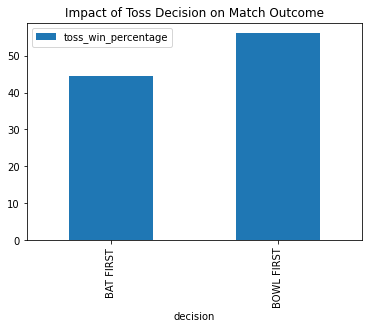

In [62]:
import matplotlib.pyplot as plt

toss_decision_wins_pd = toss_decision_wins.toPandas()
toss_decision_wins_pd.plot(kind='bar', x='decision', y='toss_win_percentage', title='Impact of Toss Decision on Match Outcome')
plt.show()


- #### Analysis on number of matches won by each team

In [63]:
# Use 'groupBy' on 'winner' column to find the number of matches won by each team for all the seasons combined

team_wins = df.groupBy('winner').agg(count('id').alias('wins'))
team_wins.show()

+------+----+
|winner|wins|
+------+----+
|   KKR| 115|
| Kochi|   6|
|    DC|  94|
|    GL|  13|
|    RR|  94|
|   LSG|   9|
|    MI| 131|
|    GT|  12|
|   CSK| 122|
|   SRH| 103|
|   RCB| 108|
|   RPS|  15|
|   PWI|  12|
|  PBKS| 101|
+------+----+



- #### Visualization of number of matches won by each team

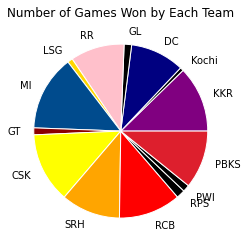

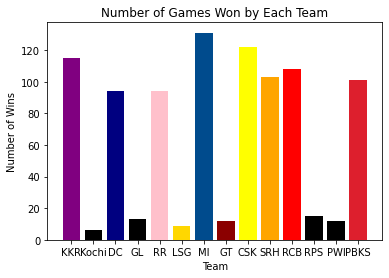

In [64]:
team_wins_pd = team_wins.toPandas()

# Plot a pie chart of the number of games won by each team

colors = ['#800080','#000000','#000080','#000000','#FFC0CB','#FFD700','#004b8d','#8b0000','#FFFF00','#FFA500','#FF0000','#000000','#000000','#DD1F2D']

plt.pie(team_wins_pd['wins'], labels=team_wins_pd['winner'] , labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' } ,colors = colors)
plt.title('Number of Games Won by Each Team')
plt.show()

plt.bar(team_wins_pd['winner'], team_wins_pd['wins'], color = colors)
plt.xlabel('Team')
plt.ylabel('Number of Wins')
plt.title('Number of Games Won by Each Team')
plt.show()

- #### Season wise number of wins for each team

In [65]:
# Group the data by 'season' and 'winner', and count the number of rows for each group

season_team_wins = df.groupBy('season', 'winner').agg(count('id').alias('wins'))

# Show the results

season_team_wins.orderBy(season_team_wins['season'].asc() , season_team_wins['wins'].desc()).show()

+------+------+----+
|season|winner|wins|
+------+------+----+
|  2008|    RR|  13|
|  2008|  PBKS|  10|
|  2008|   CSK|   9|
|  2008|    MI|   7|
|  2008|   KKR|   6|
|  2008|    DC|   5|
|  2008|   RCB|   4|
|  2008|   SRH|   2|
|  2009|   RCB|   9|
|  2009|   SRH|   8|
|  2009|    DC|   8|
|  2009|   CSK|   8|
|  2009|  PBKS|   7|
|  2009|    MI|   5|
|  2009|    RR|   5|
|  2009|   KKR|   4|
|  2010|    MI|  11|
|  2010|   CSK|  10|
|  2010|   RCB|   8|
|  2010|    DC|   7|
+------+------+----+
only showing top 20 rows



In [66]:
# Get the distinct values of the season column in ascending order

seasons = [row['season'] for row in season_team_wins.select('season').distinct().orderBy('season').collect()]

# Loop through the seasons and create separate dataframes for each year

yearwise_dataframes = {}
for season in seasons:
    # Filter the data for the current season
    season_data = season_team_wins.filter(season_team_wins.season == season)
    # Store the data in a dictionary with the season as the key
    yearwise_dataframes[season] = season_data
    # Show the data for the current season
    print('Season {}:'.format(season))
    season_data.show()


Season 2008:
+------+------+----+
|season|winner|wins|
+------+------+----+
|  2008|    RR|  13|
|  2008|    MI|   7|
|  2008|   RCB|   4|
|  2008|  PBKS|  10|
|  2008|   KKR|   6|
|  2008|    DC|   5|
|  2008|   CSK|   9|
|  2008|   SRH|   2|
+------+------+----+

Season 2009:
+------+------+----+
|season|winner|wins|
+------+------+----+
|  2009|   KKR|   4|
|  2009|    RR|   5|
|  2009|  PBKS|   7|
|  2009|   CSK|   8|
|  2009|    MI|   5|
|  2009|    DC|   8|
|  2009|   SRH|   8|
|  2009|   RCB|   9|
+------+------+----+

Season 2010:
+------+------+----+
|season|winner|wins|
+------+------+----+
|  2010|   SRH|   6|
|  2010|    DC|   7|
|  2010|   CSK|  10|
|  2010|    RR|   6|
|  2010|  PBKS|   3|
|  2010|   KKR|   7|
|  2010|    MI|  11|
|  2010|   RCB|   8|
+------+------+----+

Season 2011:
+------+------+----+
|season|winner|wins|
+------+------+----+
|  2011|    RR|   6|
|  2011|   KKR|   8|
|  2011|   SRH|   5|
|  2011|    MI|  10|
|  2011|  PBKS|   7|
|  2011|    DC|   3|


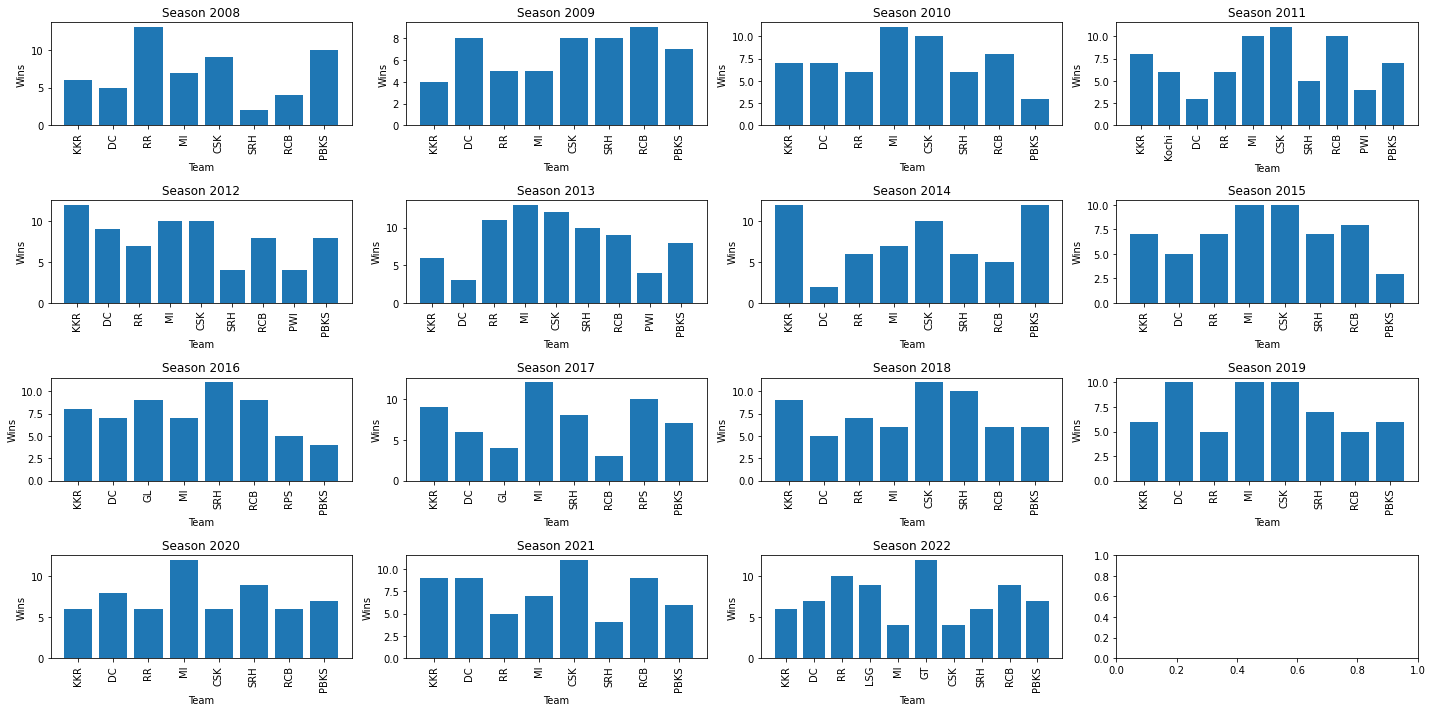

In [67]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the number of columns and rows of subplots

n_cols = 4
n_rows = (len(yearwise_dataframes) - 1) // n_cols + 1

# Use 'sorted' method to sort the seasons in ascending order

seasons = sorted([row['season'] for row in season_team_wins.select('season').distinct().collect()])

# Create the subplots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 10))

# Loop through the yearwise_dataframes dictionary and plot each dataframe

i = 0
j = 0
for season in seasons:
    df1 = yearwise_dataframes[season]
    # Convert the 'wins' column to a scalar data type
    df1 = df1.withColumn('wins', df1['wins'].cast('int'))
    # Group the rows by team and get the total number of wins per team
    df1 = df1.groupby('winner').sum('wins')
    df1 = df1.toPandas()
    # Create a bar plot for the current dataframe
    ax = axs[i, j]
    ax.bar(df1['winner'], df1['sum(wins)'])
    ax.set_title('Season {}'.format(season))
    ax.set_xlabel('Team')
    ax.set_ylabel('Wins')
    ax.tick_params(axis='x', rotation=90)
    
    # Update the row and column indices for the next subplot
    
    j += 1
    if j == n_cols:
        i += 1
        j = 0
        
# Use 'tight_layout' method to adjust the spacing between subplots and show the plot

plt.tight_layout()
plt.show()

- #### Analysis using '1st_inning_score' column

In [68]:
# Extract 1st innings runs from '1st_inning_score' column and store it in '1st_inning_runs' column

from pyspark.sql.functions import regexp_extract

df = df.withColumn('1st_inning_runs', regexp_extract(df['1st_inning_score'], r'^([^/]*)', 1))

In [69]:
# Use 'cast' method to convert the datatype of '1st_inning_runs' column to integer

from pyspark.sql.functions import col

df = df.withColumn('1st_inning_runs', col('1st_inning_runs').cast('integer'))

In [70]:
# Average 1st innings score venue wise

venue_avg_1st_inning_score = df.groupBy('venue').agg({'1st_inning_runs': 'avg'}).orderBy('avg(1st_inning_runs)', ascending=True)
venue_avg_1st_inning_score.show()


+--------------------+--------------------+
|               venue|avg(1st_inning_runs)|
+--------------------+--------------------+
|Mangaung Oval, Bl...|               135.0|
| Newlands, Cape Town|  139.42857142857142|
|The Wanderers Sta...|               144.0|
|Shaheed Veer Nara...|  146.33333333333334|
|Dr DY Patil Sport...|  146.64705882352942|
|Nehru Stadium, Kochi|               146.8|
|Buffalo Park, Eas...|  147.33333333333334|
|JSCA Internationa...|               149.0|
|Vidarbha Cricket ...|  149.33333333333334|
|   Kingsmead, Durban|               150.5|
|Narendra Modi Sta...|  154.28571428571428|
|SuperSport Park, ...|               155.7|
|Rajiv Gandhi Inte...|  157.14754098360655|
|Dr. Y.S. Rajasekh...|  157.46153846153845|
|Sawai Mansingh St...|  157.68085106382978|
|Diamond Oval, Kim...|               158.0|
|Sheikh Zayed Stad...|   158.8918918918919|
|St George's Park,...|               159.0|
|Sharjah Cricket S...|  159.03571428571428|
|Holkar Cricket St...|  160.3333

- #### Visualization on venue wise average 1st innings score

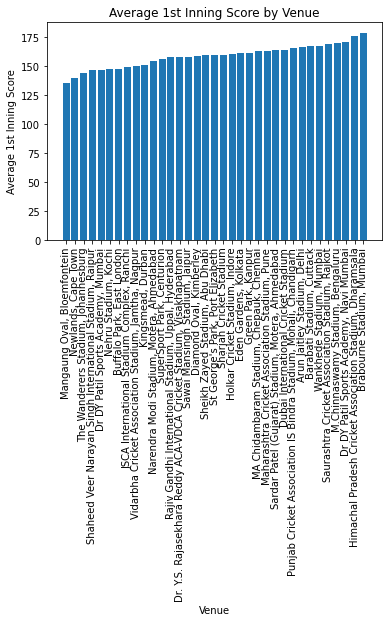

In [71]:
venues = [row['venue'] for row in venue_avg_1st_inning_score.collect()]
avg_scores = [row['avg(1st_inning_runs)'] for row in venue_avg_1st_inning_score.collect()]

plt.bar(venues, avg_scores)
plt.xticks(rotation=90)
plt.xlabel('Venue')
plt.ylabel('Average 1st Inning Score')
plt.title('Average 1st Inning Score by Venue')
plt.show()

- #### Venue wise number of wins for each team with win percentage

In [72]:
# Calculate the total number of matches played by each team at each venue

venue_team_total_matches = df.groupBy(['venue', 'home_team']).count().withColumnRenamed('count', 'total_matches')

# Calculate the number of matches won by each team at each venue

venue_team_wins = df.filter(col('winner') == col('home_team')).groupBy(['venue', 'home_team']).count().withColumnRenamed('count', 'wins')

# Join the two data frames to calculate the win percentage for each team at each venue

venue_team_win_percentage = venue_team_wins.join(venue_team_total_matches, ['venue', 'home_team']).withColumn('win_percentage', col('wins') / col('total_matches') * 100)

# Display the results

venue_team_win_percentage.orderBy(venue_team_win_percentage['total_matches'].desc() , venue_team_win_percentage['win_percentage'].desc()).show()


+--------------------+---------+----+-------------+------------------+
|               venue|home_team|wins|total_matches|    win_percentage|
+--------------------+---------+----+-------------+------------------+
|Eden Gardens, Kol...|      KKR|  45|           74|60.810810810810814|
|M.Chinnaswamy Sta...|      RCB|  37|           73| 50.68493150684932|
|Wankhede Stadium,...|       MI|  41|           68| 60.29411764705882|
|Arun Jaitley Stad...|       DC|  29|           65| 44.61538461538462|
|Rajiv Gandhi Inte...|      SRH|  33|           59|55.932203389830505|
|Punjab Cricket As...|     PBKS|  30|           56| 53.57142857142857|
|MA Chidambaram St...|      CSK|  41|           55| 74.54545454545455|
|Sawai Mansingh St...|       RR|  32|           47| 68.08510638297872|
|Maharashtra Crick...|      PWI|   4|           16|              25.0|
|Sardar Patel (Guj...|       RR|   7|           12|58.333333333333336|
|Maharashtra Crick...|      RPS|   5|           11| 45.45454545454545|
|Wankh

- #### Analysis using key players count

In [73]:
from pyspark.sql.functions import concat, array, explode, split, countDistinct, concat_ws

# Concat and explode all the key players into different rows

df = df.withColumn('key_players', concat(array(df.home_key_batsman, df.home_key_bowler, df.away_key_batsman, df.away_key_bowler)))
df = df.withColumn('key_players', explode('key_players'))
df = df.withColumn('key_players', explode(split('key_players', ',')))


In [74]:
# Frequency of each key player for all seasons combined

value_counts_key_players = df.groupBy('key_players').count()
value_counts_key_players.show()

+-------------------+-----+
|        key_players|count|
+-------------------+-----+
|      Kuldeep Yadav|   17|
|     James Faulkner|   22|
|        Odean Smith|    1|
|    Mayank Markande|    6|
|      Samuel Badree|    2|
|     Robin Peterson|    1|
|      Parthiv Patel|   37|
|     Lasith Malinga|   56|
|          Moeen Ali|   23|
|   Dilhara Fernando|    6|
|     Rahul Tripathi|   24|
|       Suresh Raina|   88|
|     Corey Anderson|   16|
|     Jaskaran Singh|    3|
|   Scott Kuggeleijn|    1|
|Chidhambaram Gautam|    2|
|       Manoj Tiwary|   24|
|   Sreenath Aravind|   13|
|   Vikramjeet Malik|    4|
|       Deepak Hooda|   17|
+-------------------+-----+
only showing top 20 rows



- #### Visualization on key players count

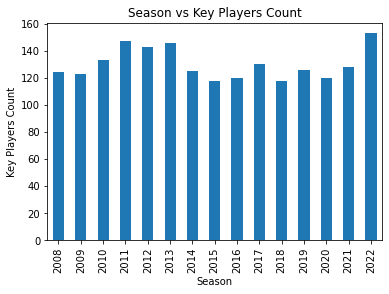

In [75]:
season_wise_key_players = df.groupBy('season').agg(countDistinct('key_players').alias('kp_count')).orderBy(col('season'))
pandasdf = season_wise_key_players.toPandas()

# create a bar plot

plot = pandasdf.plot(kind="bar", x = 'season', y = 'kp_count', legend = None)

# add title and labels for x and y axis

plt.title('Season vs Key Players Count')
plt.xlabel('Season')
plt.ylabel('Key Players Count')

# show the plot

plt.show()


- #### Venue wise key players count

In [76]:
venue_wise_key_players = df.select('venue', 'key_players').groupBy('venue')
venue_wise_key_players = venue_wise_key_players.agg(count('key_players'))
venue_wise_key_players.show()

+--------------------+------------------+
|               venue|count(key_players)|
+--------------------+------------------+
|Dubai Internation...|               368|
|St George's Park,...|                56|
|Buffalo Park, Eas...|                24|
|JSCA Internationa...|                56|
|Brabourne Stadium...|               216|
|Arun Jaitley Stad...|               584|
|Punjab Cricket As...|               448|
|Sawai Mansingh St...|               376|
| Newlands, Cape Town|                56|
|Wankhede Stadium,...|               832|
|  Green Park, Kanpur|                32|
|Dr DY Patil Sport...|               136|
|Diamond Oval, Kim...|                24|
|Sheikh Zayed Stad...|               296|
|Holkar Cricket St...|                72|
|Sharjah Cricket S...|               224|
|M.Chinnaswamy Sta...|               616|
|Himachal Pradesh ...|                72|
|Barabati Stadium,...|                48|
|Narendra Modi Sta...|                56|
+--------------------+------------